# Rev $\Delta \eta_{HH}$ validation

**Goal:** I want to check the **pulls** and post fit distribution here.

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
from glob import glob
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib import gridspec

import os
os.sys.path += ['../gp-for-flows/','../PyATLASstyle/','../../hh4b/hh4b-plots/'] 

from statUtils import getEigenvariations

from gp import *
from flows import *
from bkgPred import *

from hh4b_plots.phys_utils import get_lumi

import boost_histogram as bh
import hist

# Let's do ATLAS style plots too!
import matplotlib as mpl
import PyATLASstyle as pas
pas.applyATLASstyle(mpl)

from hh4b_plots.colors import *

%load_ext autoreload
%autoreload 2

## Open the histogram files

In [2]:
c = 'val1p1'

subDir = 'data161718-MAY21_4b_rev_deta_ggf'

modelDir = f'../gp-for-flows/models/{subDir}'

fc = f'../gp-for-flows/configs/{c}.json'
with open(fc,'r') as cfile:
    hps = json.load(cfile)

L,H,nb,K,lr,beta,p = hps['L'],hps['H'],hps['nb'],hps['K'],hps['lr'],hps['beta'],hps['p']
colTag = '_'.join(hps['cols'])

modelConfig = f'nsf_rq-coupling_{colTag}_lu_{L}_layers_H_{H}_{nb}_blocks_K_{K}_B_3_lr_{lr}_{beta}_p{p}_iter0'

nSeeds = 25

yrs = ['16','17','18']

In [3]:
hdict = {yr:{} for yr in yrs} # GP + flow prediction

for yr in yrs:
    with open(f'{modelDir}/{modelConfig}/hists_gp_100k_pipe_{yr}.json','r') as hfile:
        out = json.load(hfile)

    for k in out.keys():
        hdict[yr][k] = np.array( out[k])
        
hAll = {}

for k in hdict['16'].keys():
    if 'std' in k: 
        continue
        
    hAll[k] = np.vstack([hd[k] for yr,hd in hdict.items()]).sum(axis=0)
            
for c, tag in product(myVars+['X_hh_dEta_hh_m_hh'],['','_Xwt_cut']):
    
    k = f'{c}_SR{tag}'
    
    # Correlated errors
    stack = np.vstack([hAll[f'{k}_{i}'] for i in range(nSeeds)])
    hAll[f"{k}_std"] = np.sqrt(np.sum((stack - hAll[f'{k}_mean'])**2, axis=0) / (nSeeds-1))
        

In [4]:
myRanges,edg_3d = get_default_bins(rev_deta=True)

**Load in the data to compare**

In [5]:
myVars

['m_hh',
 'm_hh_cor2',
 'dEta_hh',
 'pT_h1',
 'pT_h2',
 'eta_h1',
 'eta_h2',
 'dphi_hh',
 'X_wt_tag']

In [6]:
hc_vars = [f'{v}_h{i}' for v, i in product(['pT','eta','phi'],[1,2])]

load_cols = d_cols + ['ntag','X_wt_tag','pass_vbf_sel'] + hc_vars

yrs = [16,17,18]

In [7]:
fDir = '../data/RR/cryptotuples/rev_deta/quad_45_full2bStats'
fnames = [f'{fDir}/data_rev_deta_Xhh_45_{yr}_NN_all_bootstraps.root' for yr in yrs]

In [8]:
nBootstraps = 25

In [9]:
dfs = []

for yr, fname in zip(yrs,fnames):
    
    print(fname)
    with uproot.open(fname) as f:
        
        norms  = [f[f'NN_norm_bstrap_med_{yr}'].all_members['fVal'],
                 f[f'NN_norm_VRderiv_bstrap_med_{yr}'].all_members['fVal']]
        norms += [f[f'NN_norm_resampling_{i}_{yr}'].all_members['fVal'] 
                  for i in range(nBootstraps)]
        
        nn_cols  = [f'NN_d24_weight{t}_bstrap_med_{yr}' for t in ['','_VRderiv']]
        nn_cols += [f'NN_d24_weight_resampling_{i}_{yr}' for i in range(nBootstraps)]
        
        dfi = f['sig'].arrays(load_cols+nn_cols,library='pd')
        
        nn_out = ['NN','NN_alt'] + [f'NN_{i}' for i in range(nBootstraps)]
        
        for ci, ni, li in zip(nn_cols, norms,nn_out):
            dfi[li] = ni * dfi[ci]
        
        dfs.append( dfi[ load_cols + nn_out ])

df = pd.concat(dfs)

../data/RR/cryptotuples/rev_deta/quad_45_full2bStats/data_rev_deta_Xhh_45_16_NN_all_bootstraps.root
../data/RR/cryptotuples/rev_deta/quad_45_full2bStats/data_rev_deta_Xhh_45_17_NN_all_bootstraps.root
../data/RR/cryptotuples/rev_deta/quad_45_full2bStats/data_rev_deta_Xhh_45_18_NN_all_bootstraps.root


In [10]:
dfi.head()

X_hh   dEta_hh        m_hh  ntag  X_wt_tag  pass_vbf_sel       pT_h1  \
0  0.429475  3.379389  423.275635     3  2.554458         False   74.939407   
1  1.384248  2.639387  728.260986     2  6.737857         False  178.092270   
2  1.312150  3.594770  532.871277     2  2.810774         False   85.474861   
3  1.537328  6.325449  862.543701     4  8.021603         False   46.469730   
4  1.169535  2.331090  958.039368     2  6.373815         False  311.108246   

        pT_h2    eta_h1    eta_h2  ...     NN_15     NN_16     NN_17  \
0   49.774651 -0.947369  2.432020  ...  0.935387  0.829231  0.862278   
1  161.860931  1.266481 -1.372906  ...  0.003207  0.002900  0.002465   
2   67.349915 -1.254720  2.340050  ...  0.007301  0.006654  0.006157   
3   25.641130 -3.190679  3.134770  ...  0.935387  0.829231  0.862278   
4  222.577942  1.312876 -1.018214  ...  0.004978  0.007529  0.005620   

      NN_18     NN_19     NN_20     NN_21     NN_22     NN_23     NN_24  
0  1.027934  0.985296  1.014516  1.001101  0.987187  1.009006  0.922538  
1  0.003184  0.006233  0.002502  0.003324  0.001843  0.003031  0.002747  
2  0.006633  0.006907  0.007677  0.006440  0.008180  0.006034  0.006056  
3  1.027934  0.985296  1.014516  1.001101  0.987187  1.009006  0.922538  
4  0.006704  0.009840  0.011180  0.008226  0.009740  0.005626  0.004859  

[5 rows x 66 columns]

In [11]:
df['dphi_hh'] = np.arccos(np.cos(df['phi_h1'] - df['phi_h2']))

In [12]:
# mask = df.eval('ntag >=4 & ~pass_vbf_sel & X_wt_tag > 1.5')
# h_3d = np.histogramdd(df.loc[mask,d_cols].values,edg_3d)[0].flatten()

In [13]:
figDir = 'figures/data161718-MAY21_4b_rev_deta_ggf'

**Show the pre-fit as a ratio plot**

In [14]:
c_fl = 'hh:darkpink'
c_rw = 'hh:darkgreen'

In [15]:
d_cols

['X_hh', 'dEta_hh', 'm_hh']

In [16]:
#bins = get_variable_bins([280, 950], res=0.09) 

cat1_labels = ['$\Delta \eta_{HH}$ < 0.5',
               '0.5 < $\Delta \eta_{HH}$ < 1',
               '1 < $\Delta \eta_{HH}$ < 1.5']
cat2_labels = ['$X_{HH}$ < 0.95', '0.95 < $X_{HH}$ < 1.6']


In [17]:
from matplotlib.ticker import AutoLocator, AutoMinorLocator, MultipleLocator, FixedLocator

In [18]:
def setup_category_ticks(bins, xcopies=1):
        loc = AutoLocator()
        loc.create_dummy_axis()
        loc.axis.get_scale = lambda: "linear"
        loc.set_view_interval(bins[0], bins[-1])
        loc2 = AutoMinorLocator()
        loc2.axis = loc.axis
        loc.axis.get_majorticklocs = loc

        trimmed_loc = loc()
        if trimmed_loc[0] < bins[0]:
            trimmed_loc = trimmed_loc[1:]
        if trimmed_loc[-1] > bins[-2]:
            trimmed_loc = trimmed_loc[:-2]

        offset = loc2()[0] + (bins[-1] - bins[0]) - loc2()[-1]
        all_maj = np.concatenate(
            [
                trimmed_loc + (bins[-1] - bins[0] + offset) * copy
                for copy in range(xcopies)
            ]
        )
        all_min = np.concatenate(
            [loc2() + (bins[-1] - bins[0] + offset) * copy for copy in range(xcopies)]
        )

        all_maj = all_maj
        trimmed_loc = trimmed_loc
        all_min = all_min
        extra_shift = offset

        return all_maj, trimmed_loc, all_min, extra_shift
        

In [20]:
mhh_bins = np.array([ 280, 305, 333, 363, 395, 431, 470, 512, 
                      558, 608, 663, 723, 788, 858, 936, 1020])

In [68]:
annotationWidth1=5.1
annotationWidth2=15.6

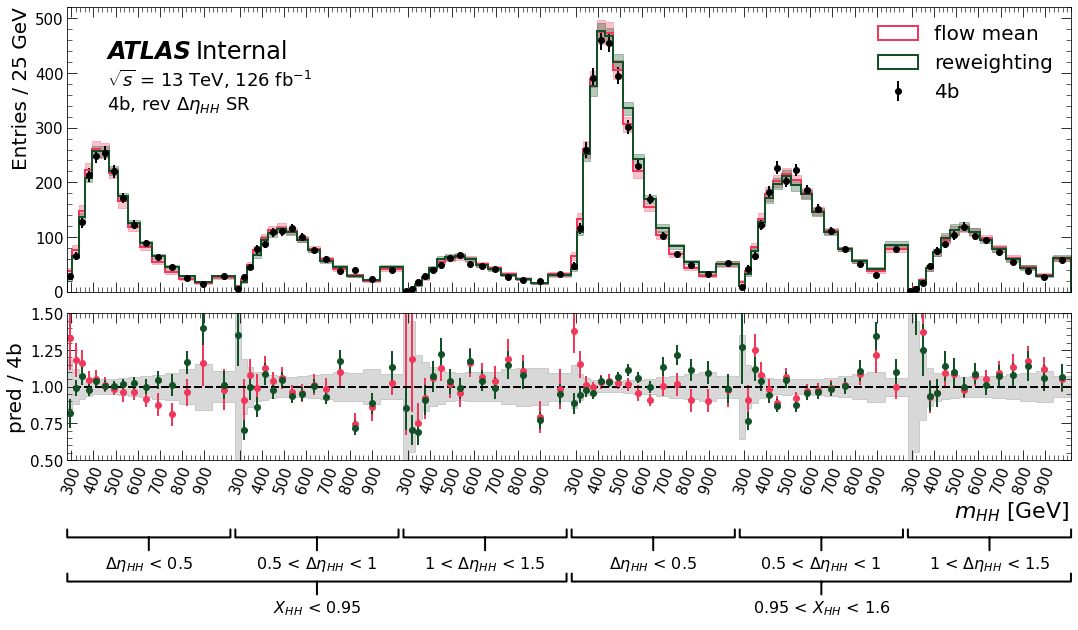

In [86]:
'''
Parameters I'll want to put in a function!!
'''
col = d_cols
Xwt_cut = True
region = 'SR'
edg=edg_3d
alpha = 0.3
ref_val = 25


'''
Start of the normal script
'''
m_2b = df.eval('ntag ==2 & ~pass_vbf_sel & X_wt_tag > 1.5')
m_4b = df.eval('ntag >=4 & ~pass_vbf_sel & X_wt_tag > 1.5')

bins = mhh_bins
xcopies = (len(edg_3d[0])-1) * (len(edg_3d[1])-1)
    
all_maj, trimmed_loc, all_min, extra_shift = setup_category_ticks(bins, xcopies=xcopies)

if type(col) == list:
    colStr = '_'.join(d_cols)
    hist = np.histogramdd

    
    ei = []
    for cidx in range(xcopies):

        shift = cidx * (bins[-1] - bins[0] + extra_shift)
        ei += list( bins[:-1] + shift )
    
    ei = ei + [bins[-1] + shift]
    
    ei = np.array(ei)     
    xi = 0.5 * ( ei[1:] + ei[:-1] ) 
    
    wi = mhh_bins[1:] -  mhh_bins[:-1]
    wi = np.array(list(wi) * xcopies)
    
else:
    hist = np.histogram
    xi = 0.5 * (edg[1:] + edg[:-1])
    ei = edg


# Obs data
h_obs = hist(df.loc[m_4b,col].values,edg)[0].flatten() 

h_obs_scaled = h_obs / wi * ref_val


# rw
h_rw  = hist(df.loc[m_2b,col].values, edg, weights=df.loc[m_2b,'NN'].values    )[0].flatten() 
h_alt = hist(df.loc[m_2b,col].values, edg, weights=df.loc[m_2b,'NN_alt'].values)[0].flatten() 
       
dh = abs(h_rw - h_alt)
  
# Also include the BS rw errors!
hs = [ hist(df.loc[m_2b,col].values, edg, weights=df.loc[m_2b,f'NN_{i}'].values)[0].flatten() 
       for i in range(nBootstraps)]

h_std = np.std(np.vstack(hs),axis=0)
 
dh = np.sqrt(dh**2 + h_std**2)
        
h_rw_scaled  = h_rw  / wi * ref_val 
dh_rw_scaled = dh  / wi * ref_val
   
# flow
k = f'{colStr}_{region}'
if Xwt_cut:
    k += '_Xwt_cut'
    
fig, (ax1,ax2) = plt.subplots(figsize=(18,10),nrows=2,sharex=True,
                              gridspec_kw={"height_ratios": [.66,.34],
                                           "hspace":0.1,
                                           "bottom":0.25},
                              )

'''
Obs data
'''
ax1.errorbar(xi, h_obs_scaled, np.sqrt(h_obs) / wi * ref_val, 
             lw=0, elinewidth=2,marker='o',color='k',label='4b')
ax2.fill_between(ei, 
                 np.append(1+1/np.sqrt(h_obs),[0]), 
                 np.append(1-1/np.sqrt(h_obs),[0]),
                 color='grey',alpha=alpha,step='post')
ax2.plot(ei[[-1,1]], [1]*2, 'k--', lw=2)

'''
Inclusively trained flow
'''
nom = hAll[f'{k}_mean']
std = hAll[f'{k}_std']

ax1.hist(xi, ei, weights=nom/wi*ref_val, color=c_fl,
         label='flow mean', lw=2,histtype='step')   

ax1.fill_between(ei,
                 np.append((nom+std)/wi*ref_val,[0]),
                 np.append((nom-std)/wi*ref_val,[0]),
                 color=c_fl,step='post',alpha=alpha)

ax2.errorbar(xi, nom/h_obs, std/h_obs,lw=0,elinewidth=2,
             marker='o',
             color=c_fl,ecolor=c_fl)

'''
Reweighting histograms
'''
ax1.hist(xi, ei, weights=h_rw_scaled, color=c_rw,
         label='reweighting',lw=2,histtype='step')

ax1.fill_between(ei,
                 np.append(h_rw_scaled+dh_rw_scaled,[0]),
                 np.append(h_rw_scaled-dh_rw_scaled,[0]),
                 color=c_rw,step='post',alpha=alpha)

ax2.errorbar(xi, h_rw/h_obs, dh/h_obs,lw=0,elinewidth=2,
             marker='o', color=c_rw,ecolor=c_rw)


ax2.set_xlabel('$m_{HH}$ [GeV] ',x=1,ha='right',fontsize=22)
ax1.set_ylabel(f'Entries / {ref_val} GeV',y=1,ha='right',fontsize=20)
ax2.set_ylabel('pred / 4b',fontsize=20)

ax1.legend(fontsize=20)
ax1.set_xlim(ei[[0,-1]])
ax2.set_ylim(0.5,1.5)

for ax in [ax1,ax2]:
    ax.xaxis.set_major_locator(FixedLocator(all_maj))
    ax.yaxis.set_major_locator(AutoLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.xaxis.set_minor_locator(FixedLocator(all_min))

    maj_labels = [f"{xtl:.0f}" for xtl in trimmed_loc] * xcopies

ax2.xaxis.set_ticklabels(maj_labels, rotation=70)

pas.makeATLAStag(ax1, fig, first_tag='Internal',
                 second_tag=r"$\sqrt{s}$ = 13 TeV, 126 fb$^{-1}$"+\
                             "\n4b, rev $\Delta \eta_{HH}$ SR",
                 ymax=.8,line_spacing=0.15,
                 fontsize_title=24,fontsize_label=18)

'''
Draw the hierarchical version of the annotations
'''
xlocs = []
for cidx, cat_name in enumerate(cat1_labels * len(cat2_labels)):
    xloc = (bins[-1] + bins[0]) / 2.0 + cidx * (
        bins[-1] - bins[0] + extra_shift
    )
    #print(xloc)
    ax2.annotate(
        cat_name,
        xy=(xloc, 0.15),
        xytext=(xloc, 0.12),
        xycoords=("data", "figure fraction"),
        fontsize=16,
        ha="center",
        va="top",
        arrowprops=dict(
            arrowstyle=f"-[, widthB={annotationWidth1}, lengthB=0.5",
            lw=2.0,
        ),
    )

    xlocs.append(xloc)

    
i = len(cat1_labels) // 2
xlocs2 = [
    xlocs[j * len(cat1_labels) + i] for j in range(len(cat2_labels))
]
for xloc, cat_name in zip(xlocs2, cat2_labels):

    #print(xloc,cat_name)
    ax2.annotate(
        cat_name,
        xy=(xloc, 0.08),
        xytext=(xloc, 0.05),
        xycoords=("data", "figure fraction"),
        fontsize=16,
        ha="center",
        va="top",
        arrowprops=dict(
            arrowstyle=f"-[, widthB={annotationWidth2}, lengthB=0.5",
            lw=2.0,
        ),
    )

plt.savefig(f'{figDir}/m_hh_cats.pdf',bbox_inches='tight')
plt.show()

In [87]:
sum(h_obs)/sum(nom)

0.9875744318589554

In [88]:
sum(h_obs)/sum(h_rw)

0.9787590850867299

**Wow!** The closure is 2x as good!!

In [ ]:
figDir

In [ ]:
tag = '_SR_Xwt_cut'
hd=hAll

for c, nb, r, xl in zip(myVars, bis, myRanges, varLabels):

    if c == 'm_hh_cor2': 
        continue
    
    fig, (ax1,ax2) = plt.subplots(figsize=(6,6),nrows=2,sharex=True,
                              gridspec_kw={"height_ratios": [.66,.34],
                                           "hspace":.1})

    e = np.linspace(*r,nb+1)
    xx = 0.5 * (e[1:] + e[:-1])

    h_2b = np.histogram(df.loc[mask,c].values,nb,r)[0]
    print(h_2b.shape)
    ax1.errorbar(xx,h_2b,np.sqrt(h_2b),color='k',lw=0, 
                 elinewidth=2,marker='.',label='4b',zorder=5)

    
    ax2.plot(e[[0,-1]],[1]*2,'navy',ls='--')

    nom = hd[f'{c}{tag}_mean']
    std = hd[f'{c}{tag}_std']

    ax1.fill_between(xx,nom+std,nom-std,color='mediumturquoise',)
    ax1.plot(xx,nom,color='navy',lw=1,label='flow')           

    
    ax2.fill_between(xx,1+std/nom,1-std/nom,
                     color='mediumturquoise',alpha=.5,zorder=0)
    
    m = nom != 0
    ax2.errorbar(xx[m],
                 h_2b[m]/nom[m],
                 std[m]/h_2b[m],
                 color='k',marker='.',lw=0,elinewidth=2)           

    ax2.set_xlabel(xl,x=1,ha='right',fontsize=18)
    ax2.set_ylabel('4b / pred')
    ax1.set_ylabel('Entries',y=1,ha='right',fontsize=18)
    ax1.set_title('min_dR: rev $\Delta \eta_{HH}$ 4b SR, Xwt cut',x=0,loc='left')

    ax1.legend(fontsize=12)
    ax1.set_xlim(e[[0,-1]])
    ax2.set_ylim(0.5,1.5)

    plt.savefig(f'{figDir}/{c}{tag}.pdf',bbox_inches='tight')
    
    plt.show()

Is it just a norm I can fit?

NameError: name 'mask' is not defined

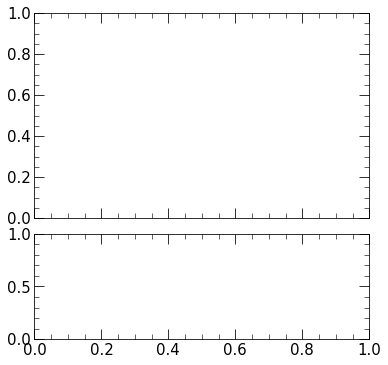

In [ ]:
tag = '_SR_Xwt_cut'
hd=hAll

for c, nb, r, xl in zip(myVars, bis, myRanges, varLabels):

    if c == 'm_hh_cor2': 
        continue
    
    fig, (ax1,ax2) = plt.subplots(figsize=(6,6),nrows=2,sharex=True,
                              gridspec_kw={"height_ratios": [.66,.34],
                                           "hspace":.1})

    e = np.linspace(*r,nb+1)
    xx = 0.5 * (e[1:] + e[:-1])

    h_2b = np.histogram(df.loc[mask,c].values,nb,r)[0]
    print(h_2b.shape)
    ax1.errorbar(xx,h_2b,np.sqrt(h_2b),color='k',lw=0, 
                 elinewidth=2,marker='.',label='4b',zorder=5)

    
    ax2.plot(e[[0,-1]],[1]*2,'navy',ls='--')

    nom = hd[f'{c}{tag}_mean']
    std = hd[f'{c}{tag}_std']

    
    s = np.sum(h_2b) / np.sum(nom)
    nom *= s
    std *= s
    
    ax1.fill_between(xx,nom+std,nom-std,color='mediumturquoise',)
    ax1.plot(xx,nom,color='navy',lw=1,label='norm flow')           

    
    ax2.fill_between(xx,1+std/nom,1-std/nom,
                     color='mediumturquoise',alpha=.5,zorder=0)
    
    m = nom != 0
    ax2.errorbar(xx[m],
                 h_2b[m]/nom[m],
                 std[m]/h_2b[m],
                 color='k',marker='.',lw=0,elinewidth=2)           

    ax2.set_xlabel(xl,x=1,ha='right',fontsize=18)
    ax2.set_ylabel('4b / pred')
    ax1.set_ylabel('Entries',y=1,ha='right',fontsize=18)
    ax1.set_title('min_dR: rev $\Delta \eta_{HH}$ 4b SR, Xwt cut',x=0,loc='left')

    ax1.legend(fontsize=12)
    ax1.set_xlim(e[[0,-1]])
    ax2.set_ylim(0.5,1.5)

    #plt.savefig(f'figures/{subDir}/trainYrComb/{c}_{tag}.pdf',bbox_inches='tight')
    
    plt.savefig(f'{figDir}/{c}_{tag}_normCorr.pdf',bbox_inches='tight')
    
    plt.show()

Ok - so this is _not_ as great as we were seeing with the 1% 2b dataset, but I _think_ it's really not bad!!

## Check the 3d discriminant in the CR ad VR

In [ ]:
crs = []

for fname in fnames:
    with uproot.open(fname) as f:
        crs.append( f['control'].arrays(load_cols[:6],library='pd') )

cr = pd.concat(crs)

In [ ]:
nom

In [ ]:
np.vstack([hAll[f'dEta_hh_m_hh_CR_Xwt_cut_{i}'] for i in range(nSeeds)]).shape

In [ ]:
fig, (ax1,ax2) = plt.subplots(figsize=(10,6),nrows=2,sharex=True,
                              gridspec_kw={"height_ratios": [.66,.34],
                                           "hspace":0.1})
nom = hAll['dEta_hh_m_hh_CR_Xwt_cut_mean']

h_list = np.vstack([hAll[f'dEta_hh_m_hh_CR_Xwt_cut_{i}'] for i in range(nSeeds)])
std = np.std(h_list,axis=0)

m_CR = cr.eval('ntag >=4 & ~pass_vbf_sel & X_wt_tag > 1.5')
h_cr = np.histogramdd(cr.loc[m_CR,d_cols[1:]].values,edg_3d[1:])[0].flatten()


ax1.plot(nom,color='navy',label='flow mean',lw=1)  

ax1.fill_between(range(len(nom)),nom+std,nom-std,color='mediumturquoise',
                 label='flow std')
ax1.errorbar(range(len(nom)), h_cr, np.sqrt(h_cr), 
             lw=0, elinewidth=2,marker='o',color='k',label='4b')

ax2.set_xlabel('$m_{hh}$ in cats [arbitrary units]',x=1,ha='right',fontsize=18)
ax1.set_ylabel('Entries',y=1,ha='right',fontsize=18)
ax1.set_title('min_dR: rev $\Delta \eta_{HH}$ 4b CR, Xwt cut',x=0,loc='left')
ax2.set_ylabel('4b / pred',fontsize=18)

ax1.legend()
ax1.set_xlim(0,45)
ax2.set_ylim(0.5,1.5)

ax2.fill_between(range(len(nom)),1+std/nom,1-std/nom,
                 color='mediumturquoise',label='flow std')
ax2.plot([0,len(nom)], [1]*2,lw=2,color='navy')

ax2.errorbar(range(len(nom)), h_cr/(nom), np.sqrt(h_cr)/(nom), 
             lw=0, elinewidth=2,marker='o',color='k',label='4b')


plt.savefig(f'{figDir}/m_hh_cats_CR.pdf',bbox_inches='tight')

plt.show()

In [ ]:
vrs = []

for fname in fnames:
    with uproot.open(fname) as f:
        vrs.append( f['validation'].arrays(load_cols[:6],library='pd') )

vr = pd.concat(vrs)

In [ ]:
fig, (ax1,ax2) = plt.subplots(figsize=(10,6),nrows=2,sharex=True,
                              gridspec_kw={"height_ratios": [.66,.34],
                                           "hspace":0.1})
nom = hAll['dEta_hh_m_hh_VR_Xwt_cut_mean']

h_list = np.vstack([hAll[f'dEta_hh_m_hh_VR_Xwt_cut_{i}'] for i in range(nSeeds)])
std = np.std(h_list,axis=0)

m_VR = vr.eval('ntag >=4 & ~pass_vbf_sel & X_wt_tag > 1.5')
h_vr = np.histogramdd(vr.loc[m_VR,d_cols[1:]].values,edg_3d[1:])[0].flatten()

ax1.plot(nom,color='navy',label='flow mean',lw=1)  

ax1.fill_between(range(len(nom)),nom+std,nom-std,color='mediumturquoise',
                 label='flow std')
ax1.errorbar(range(len(nom)), h_vr, np.sqrt(h_vr), 
             lw=0, elinewidth=2,marker='o',color='k',label='4b')

ax2.set_xlabel('$m_{hh}$ in cats [arbitrary units]',x=1,ha='right',fontsize=18)
ax1.set_ylabel('Entries',y=1,ha='right',fontsize=18)
ax1.set_title('min_dR: rev $\Delta \eta_{HH}$ 4b CR, Xwt cut',x=0,loc='left')
ax2.set_ylabel('4b / pred',fontsize=18)

ax1.legend()
ax1.set_xlim(0,45)
ax2.set_ylim(0.5,1.5)

ax2.fill_between(range(len(nom)),1+std/nom,1-std/nom,
                 color='mediumturquoise',label='flow std')
ax2.plot([0,len(nom)], [1]*2,lw=2,color='navy')

ax2.errorbar(range(len(nom)), h_vr/(nom), np.sqrt(h_vr)/(nom), 
             lw=0, elinewidth=2,marker='o',color='k',label='4b')


plt.savefig(f'{figDir}/m_hh_cats_VR.pdf',bbox_inches='tight')

plt.show()

**nice!...** This looks great!